# Table of Contents

I. [Exploratory Data Analysis](#i-exploratory-data-analysis)
1. [Data](#1-data)
2. [Understanding The dataset](#2-understanding-the-dataset)
3. [Features](#3-features)

**Questions Shortcut**
1. [How many times the equipment has failed](#33-counting-failures)
2. [Equipment failures by setup configurations (Preset 1 and Preset 2)]()
3. [Equipment failures by their nature/root cause according to parameter readings (temperature, pressure, and others)]()
4. [Create a model (or models) using the technique you think is most appropriate and measure its performance]()
5. [Analyze variable importance]()

# I. Exploratory Data Analysis
After all, we need to understand the context before any machine learning / modeling procedure.

## 0. Enviroment

In [126]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [198]:
from scipy.stats import shapiro

In [127]:
pd.options.display.max_columns = None

## 1. Data

The dataset contains anonymized time series records of a machine's operation from an FPSO. The recorded variables are as follows:
1.	Cycle: Sequential identifier of measurement cycles.
2.	Preset_1 & Preset_2: Variables that control a specific operating point (OP) of the machine.
3.	Temperature: Temperature recorded in the equipment.
4.	Vibrations (X, Y & Z): Vibrations along the machine's axes.
5.	Frequency: Operating frequency of the machine.
6.	Fail: Variable indicating whether the machine is in a failure state at the given timestamp.

In [128]:
df_oge = pd.read_excel("../data/01_raw/oge_data.xlsx")

## 2. Understanding the dataset
Simple validation of schema, shape and presets.

In [129]:
df_oge = df_oge.sort_values("Cycle")

In [130]:
display(
    df_oge.head(),
    df_oge.shape,
    df_oge.dtypes,
    df_oge.isna().sum()
)

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,False
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,False
2,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,False
3,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,False
4,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,False


(800, 10)

Cycle            int64
Preset_1         int64
Preset_2         int64
Temperature    float64
Pressure       float64
VibrationX     float64
VibrationY     float64
VibrationZ     float64
Frequency      float64
Fail              bool
dtype: object

Cycle          0
Preset_1       0
Preset_2       0
Temperature    0
Pressure       0
VibrationX     0
VibrationY     0
VibrationZ     0
Frequency      0
Fail           0
dtype: int64

In [131]:
# Checking if there's incorrect cycle id
df_id = df_oge[["Cycle"]].reset_index()

df_id["index"] = df_id["index"]+1
df_id["check"] = df_id.eval("index == Cycle")

assert df_id.query("check == False").shape[0] == 0

In [132]:
# number of presets of each type and its use frequency
display(
    df_oge["Preset_1"].value_counts(),
    df_oge["Preset_2"].value_counts(),
)

Preset_1
2    281
1    264
3    255
Name: count, dtype: int64

Preset_2
7    109
6    101
2    101
3    101
5    100
8    100
1     95
4     93
Name: count, dtype: int64

In [299]:
# number of presets combinations and how frequent they are used
df_oge["PresetComb"] = df_oge[["Preset_1", "Preset_2"]].astype(str).agg("".join, axis=1)

df_oge["PresetComb"].value_counts()

PresetComb
13    43
24    40
25    40
38    39
17    38
12    38
26    37
28    37
27    37
16    34
11    34
37    34
22    34
33    32
31    31
34    31
15    31
36    30
21    30
35    29
32    29
23    26
18    24
14    22
Name: count, dtype: int64

==========================================================================================================
- Which variables are manipulated by Preset 1 and 2?
- Preset 2 has more options. Is there a reason for this?
- How each OP (combination of Presets 1 and 2) impact the system (above all, temperature and pressure)?
- Which combination makes the equipment more suspectible to failure?

_Questions discussed further on ([Presets](#32-presets))._

==========================================================================================================

## 3. Features

In [133]:
# Defining features
features = [
    "Temperature",
    "Pressure",
    "VibrationX",
    "VibrationY",
    "VibrationZ",
    "Frequency",
]

### 3.1. Central Tendency

In [163]:
def calculate_measures(
    df: pd.DataFrame,
    features: list,
    measures: list
) -> pd.DataFrame:
    """
    Calculate central tendency `measures` of `features` in a given `dataframe`.
    """

    df_measures = df.agg({feature: measures for feature in features})
    df_measures.loc["range"] = df_measures.loc["max"] - df_measures.loc["min"]

    return df_measures

In [177]:
# some measures of central tendency
measures = ["min", "max", "mean", "median", "std", "skew", "kurtosis"]
df_op_measures = calculate_measures(df_oge[~df_oge["Fail"]], features, measures)
df_fail_measures = calculate_measures(df_oge[df_oge["Fail"]], features, measures)

df_measures = pd.concat(
    [
        df_op_measures.add_suffix("_op"),
        df_fail_measures.add_suffix("_fail")
    ],
    axis=1
)

df_measures.transpose().sort_index()

,min,max,mean,median,std,skew,kurtosis,range
Frequency_fail,48.923777,178.090303,99.812745,99.212676,22.960578,0.432420,1.959404,129.166526
Frequency_op,4.380101,158.811673,65.382995,62.687313,27.943436,0.384159,-0.271089,154.431573
Pressure_fail,50.822002,189.995681,116.422540,110.619156,30.040055,0.519393,-0.150417,139.173679
Pressure_op,3.480279,185.406401,75.632790,71.911241,30.561615,0.524902,0.149601,181.926122
Temperature_fail,48.091962,150.880308,92.469125,90.928964,21.683670,0.186035,0.739854,102.788346
Temperature_op,2.089354,255.607829,67.176884,64.814877,24.824880,1.838670,9.427262,253.518475
VibrationX_fail,20.120467,200.749598,100.167190,98.043755,28.109402,0.672335,2.376813,180.629130
VibrationX_op,3.846343,230.861142,71.494803,66.358594,30.415831,1.303281,3.448406,227.014799
VibrationY_fail,50.481820,193.569947,122.481159,122.115118,30.861777,0.123631,-0.430280,143.088127
VibrationY_op,10.057744,176.197917,68.318455,63.516837,29.010220,0.652150,0.188877,166.140173


==========================================================================================================

Some info that might help analysing the mesures above

**How close to a normal the features distribution are?**

- mean and median are approximately equal
- skewness is close to 0 (symmetric distribution)
- kurtosis is close to 0 (similar flatness to the normal distribution)

**Extra**
- kurtosis > 0 indicates more concetrated distribution
- kurtosis < 0 indicates less concetrated (more dispersed) distribution
- skewness > 0 indicates long tail on the righ side of the distribution
- skewness < 0 indicates long tail on the left side of the distribution

==========================================================================================================

Since validating text values is not ideal, lets take a look on the distributions:

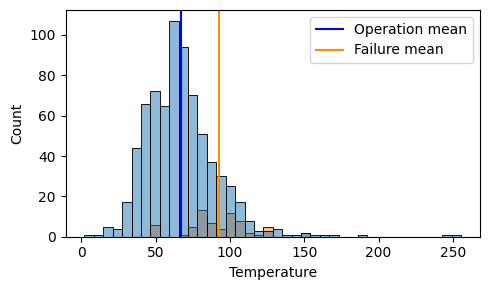

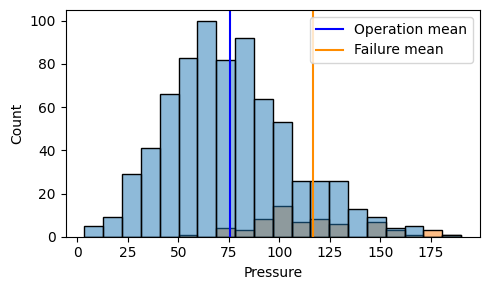

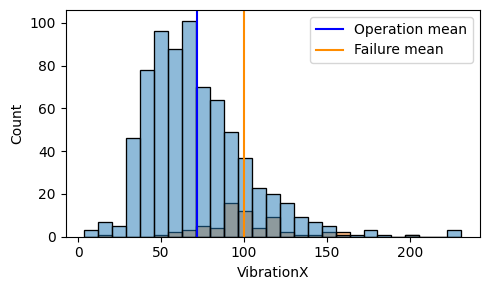

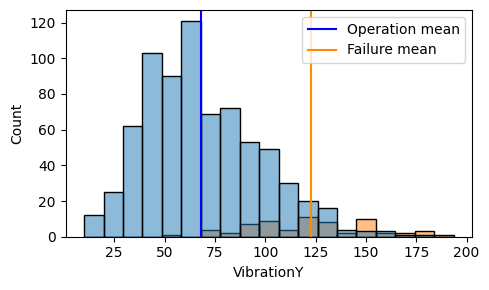

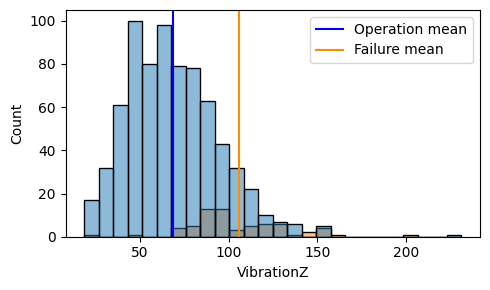

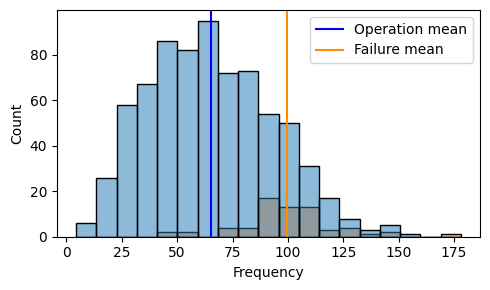

In [123]:
for feature in features:
    mean = df_oge.groupby("Fail")[feature].mean()
    op_mean = mean.loc[False]
    fail_mean = mean.loc[True]

    plt.figure(figsize=(5, 3))
    sns.histplot(
        data=df_oge,
        x=feature,
        hue="Fail",
    )

    plt.axvline(op_mean, color="blue")
    plt.axvline(fail_mean, color="darkorange")

    plt.legend([f"Operation mean", f"Failure mean"])

    plt.tight_layout()
    plt.show()

==========================================================================================================
- At first sight `Temperature`, `Pressure` and `Frequency` distributions seem normal;
- All `Vibration` variables seems to have positive skewness;
- Since modeling failures is the objective, normal distributions can help us with more basic methods such as MAD (Median Absolute Deviation) to set a baseline model;
- That said, the values when normal and failure conditions tend to overlap, giving more complexity to the problem.

==========================================================================================================

Lets check if those distributions are normal using the Shapiro-Wilk test

_H0 = data was drawn from a normal distribution_

In [ ]:
shapiro_results = {feature: shapiro(df_oge[feature]) for feature in features}

df_shapiro_results = pd.DataFrame(shapiro_results, index=["statistic", "pvalue"])
df_shapiro_results

,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency
statistic,9.178667e-01,9.801918e-01,9.388416e-01,9.607614e-01,9.622515e-01,9.855061e-01
pvalue,2.016952e-20,6.077752e-09,1.295789e-17,8.234553e-14,1.672456e-13,4.088370e-07


Since all p-values are way below 0.05, the null hypothesis is reject. In other words, none of the distributions are normal.

### 3.2. Variable changes over time

In [440]:
def plot_time_series(
    df_oge: pd.DataFrame,
    features: list,
    fast_moving_mean: bool = True,
    slow_moving_mean: bool = True,
    hide_raw_data: bool = False,
    figsize: tuple = (15, 5)
) -> None:
    """
    Generate time series chart with failures identified for each feature in `features` list.
    
    Args
    ---
    df_oge (pd.DataFrame):
        Dataframe containing time series records of a machine's operation (`Cycle column required`).
    features (list):
        Variables to analyse over time.
    fast_moving_mean (bool):
        Plot moving avarege of the `feature` using a small range of time (2 Cycles/measurements).
    slow_moving_mean (bool):
        Plot moving avarege of the `feature` using a large range of time (or Cycles/measurements).
    hide_raw_data (bool):
        Hide raw measurements from chart to avoid noises.
    """

    x = df_oge["Cycle"]
    for feature in features:
        legend = []
        plt.figure(figsize=figsize)
    
        if not hide_raw_data:
            op_series = np.where(df_oge["Fail"], np.nan, df_oge[feature])
            plt.plot(x, op_series, color='b', linewidth=1)

            legend.append(feature)

        if fast_moving_mean:
            fmm = df_oge["Pressure"].rolling(3, min_periods=2).mean()
            plt.plot(x, fmm, color="navy", alpha=.5)
    
            legend.append("Fast Moving Mean")
    
        if slow_moving_mean:
            smm = df_oge["Pressure"].rolling(12, min_periods=2).mean()
            plt.plot(x, smm, color="black", alpha=.8)

            legend.append("Slow Moving Mean")

        fail_series = np.where(df_oge["Fail"], df_oge[feature], np.nan)
        fail_mean = fail_series[~np.isnan(fail_series)].mean()

        plt.plot(x, fail_series, color='r', linewidth=1, marker="o", markersize=3)
        plt.axhline(fail_mean, color="red", linestyle="--")

        legend += [f"Failure {feature}", f"Avarage failure {feature}"]
        plt.xlabel("Cycle")
        plt.legend(legend)
        plt.title(f"{feature} over time")
        plt.show()

    return None

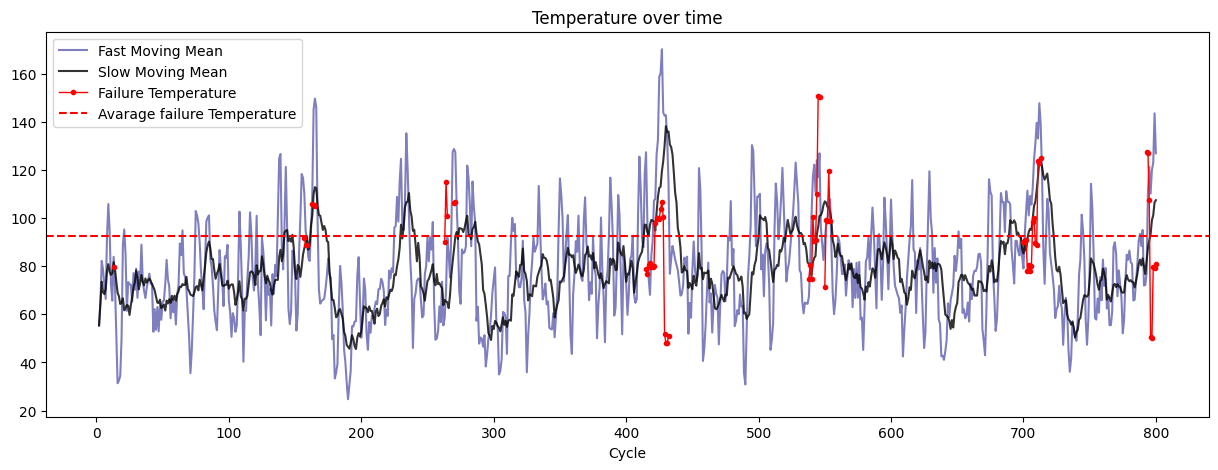

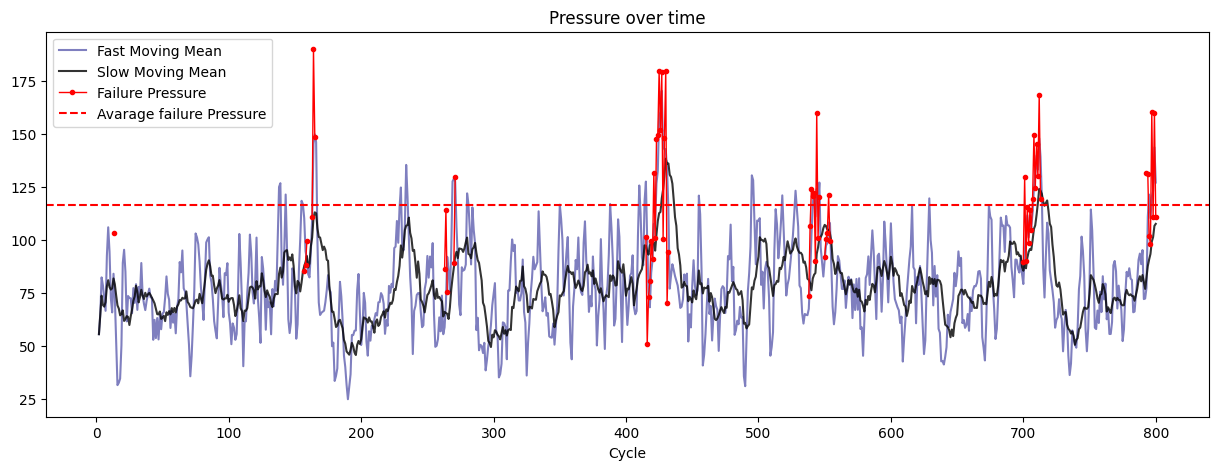

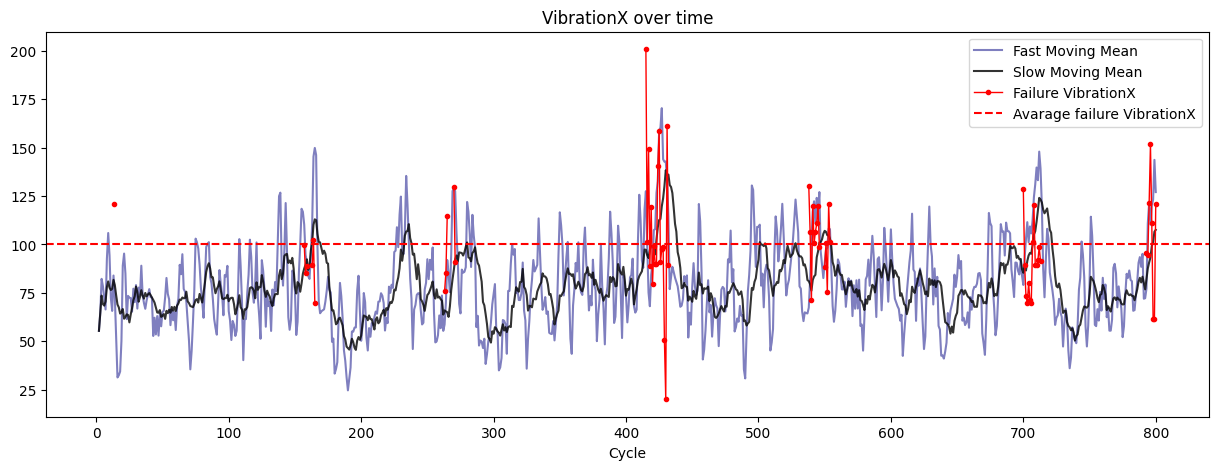

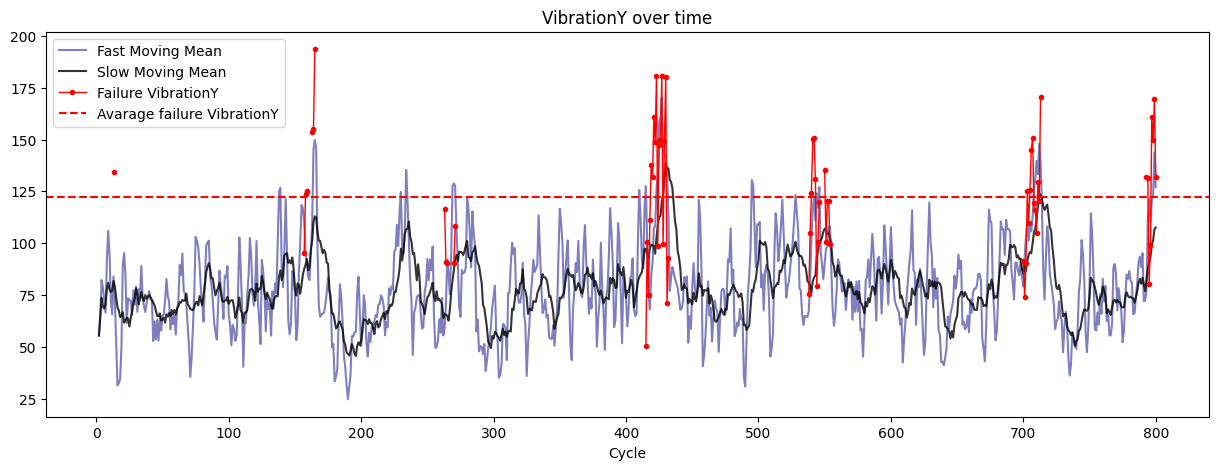

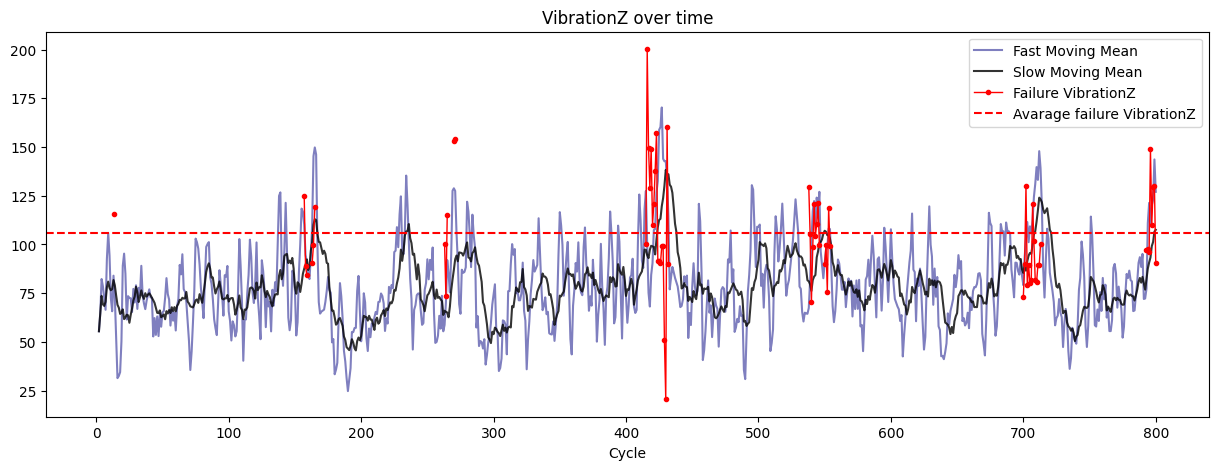

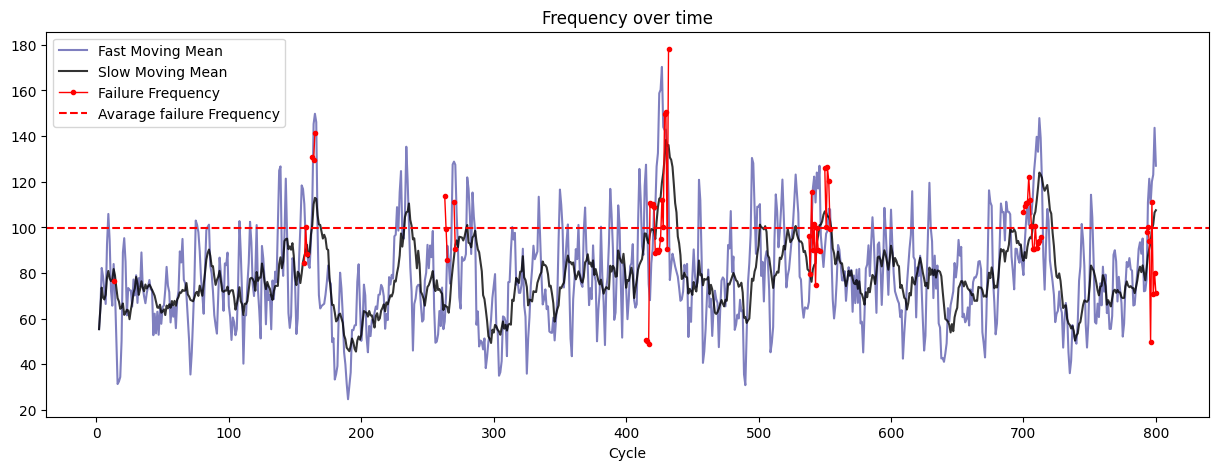

In [441]:
plot_time_series(df_oge, features, hide_raw_data=True)

==========================================================================================================

- Most of the failures seems to occur when `Pressure` goes over an certain value (~120), increasing the `Vibration` on Y and Z directions;
- Feailures are unlikely to occur with negative deviations, probabily because the system/sensor is set to recognize high signals as real problems;
- There is no direct pattern that indicates how Temperature changes on failures scenarios;

==========================================================================================================

## 3.3. Counting failures
Generally failures are not a single point on a time series, but a range. With that in mind, we can calculate how many times the equipment has failed.

In [442]:
df_oge

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail,PresetComb
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,False,36
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,False,24
2,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,False,21
3,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,False,23
4,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,False,25
...,...,...,...,...,...,...,...,...,...,...,...
795,796,2,6,50.469522,98.235421,151.585252,99.341380,148.838481,49.841400,True,26
796,797,1,4,49.985270,160.433640,110.953010,160.777175,109.917566,110.919290,True,14
797,798,1,4,79.777294,110.535405,61.334995,149.577811,129.463843,70.853353,True,14
798,799,2,8,79.360314,159.985443,61.762879,169.773831,130.213426,80.113540,True,28


## 4. Presets
How preset combinations changes the equipment conditions?

_Hypothesis: Preset combinations have well defined ranges of Temperature and Pressure_

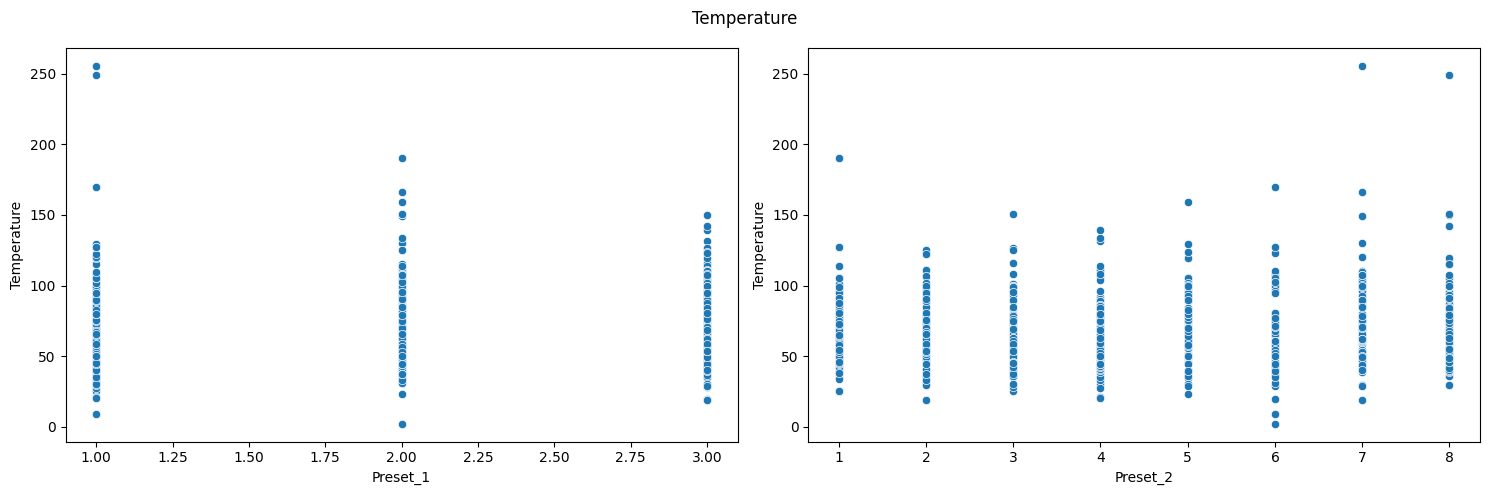

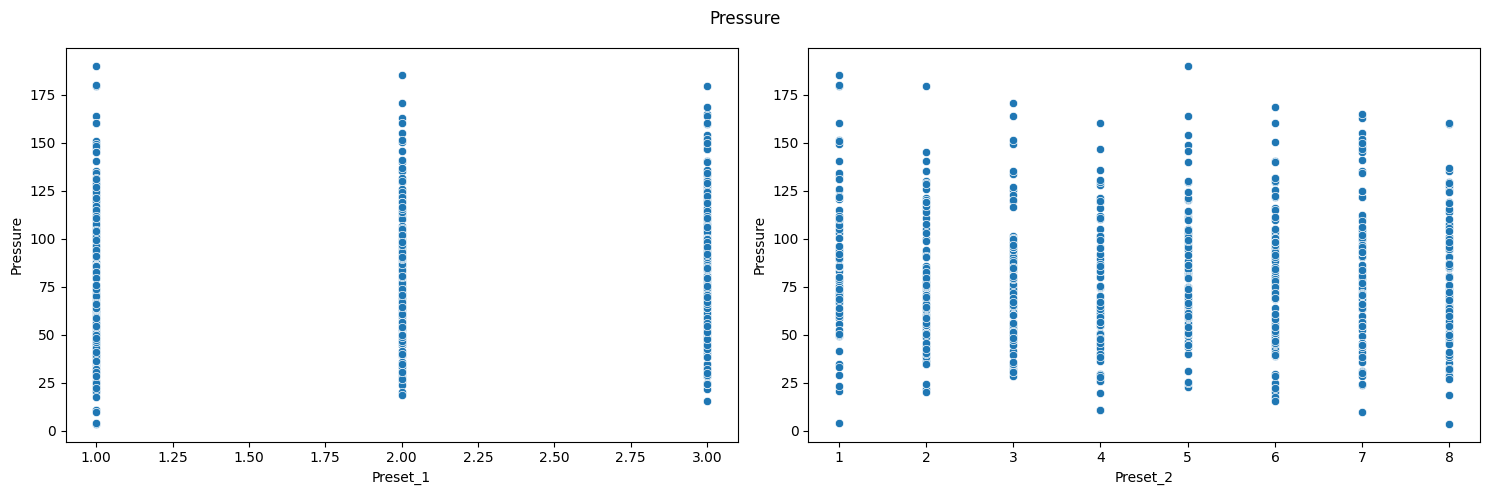

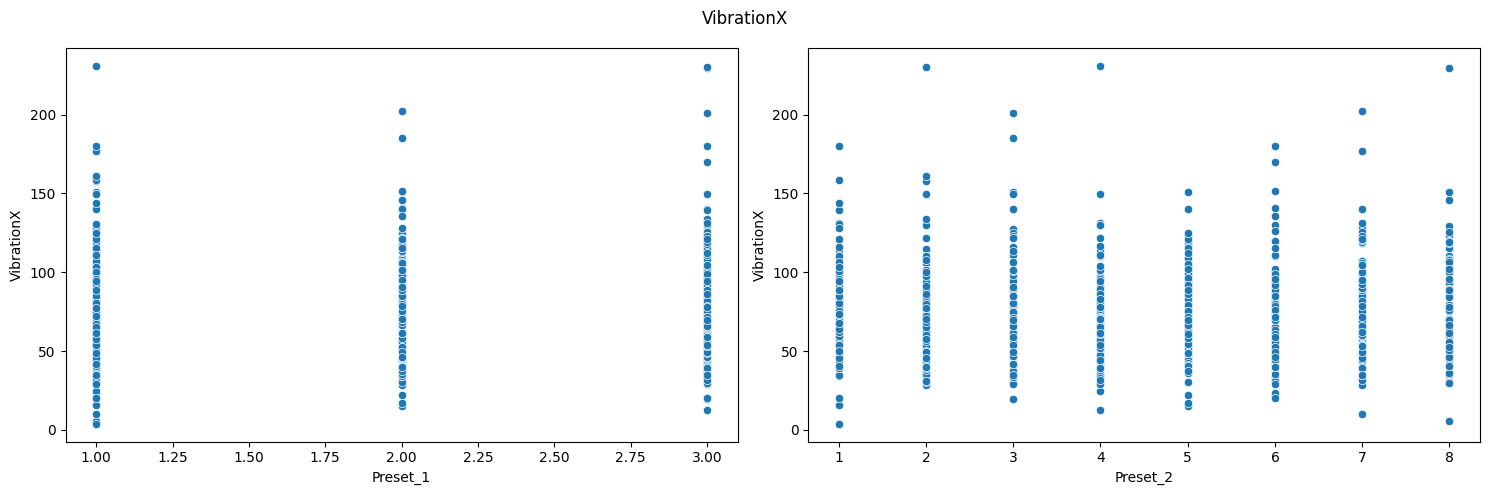

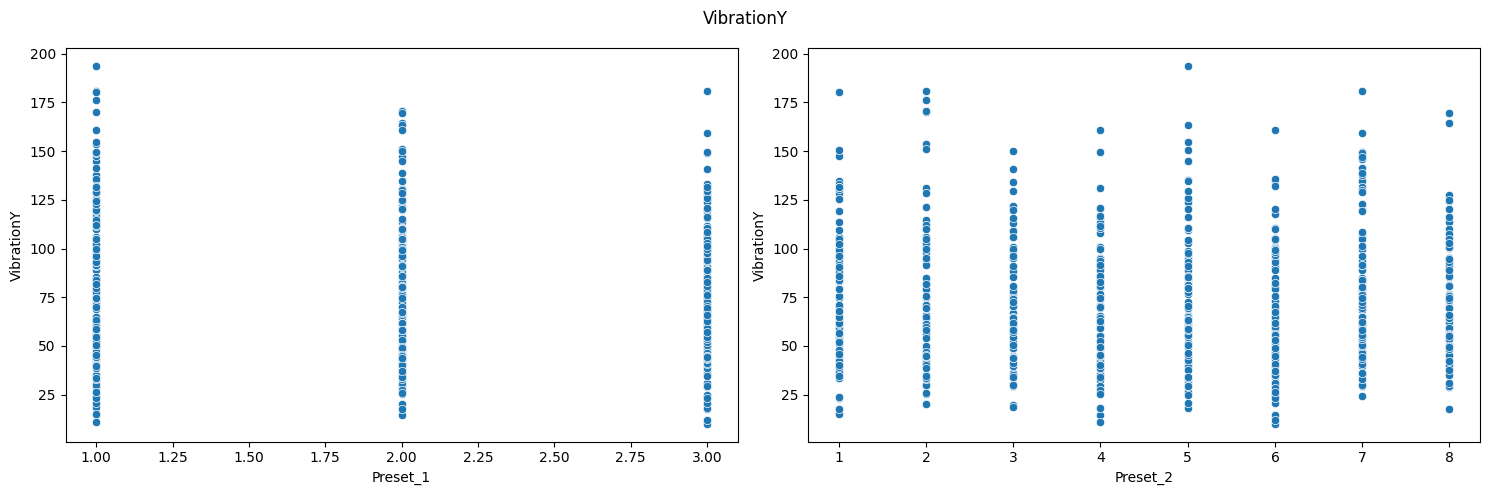

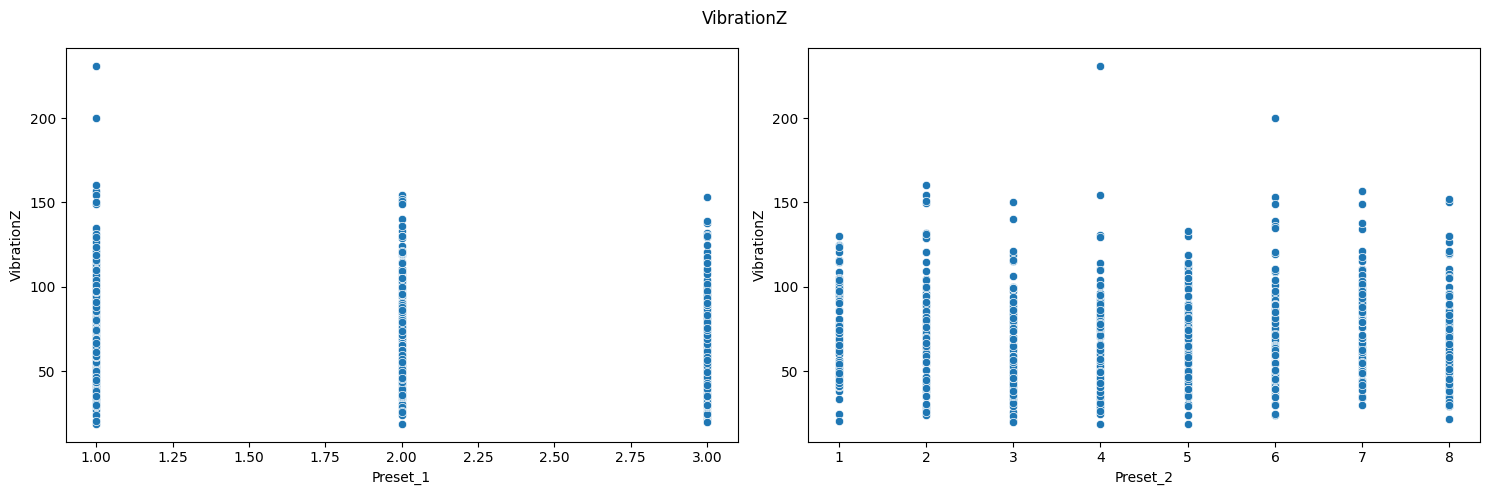

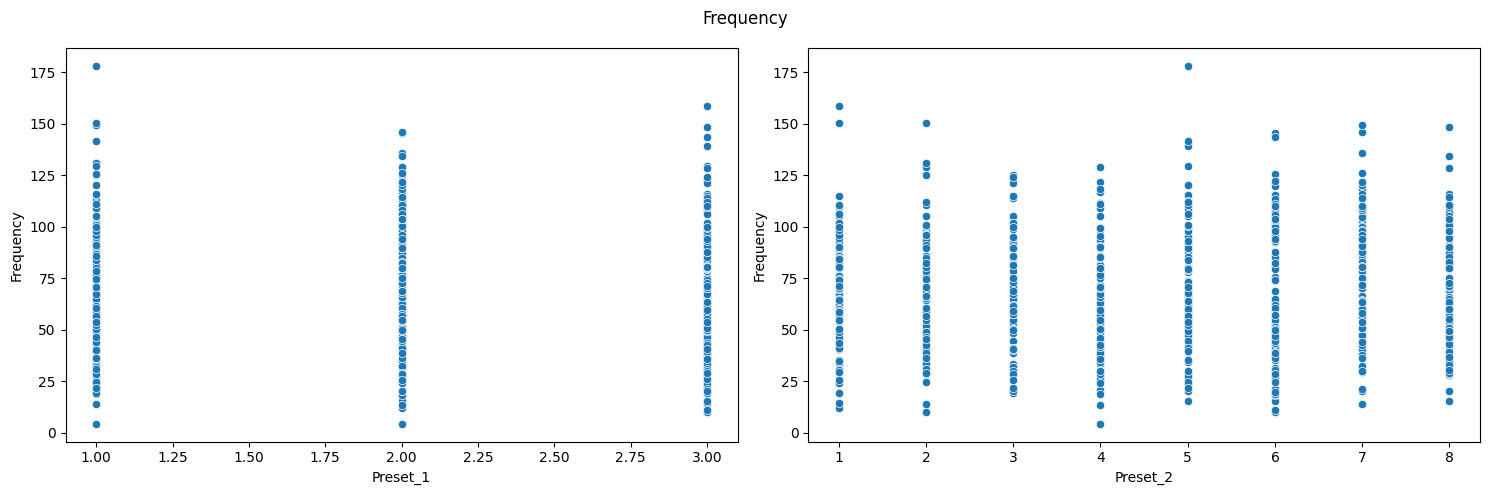

In [ ]:
# Isolated presets
# Since the preset 1 and 2 are combined to create an Operational Point, we must'n expect much of the isolated analysis.
for variable in features:
    fig, ax = plt.subplots(nrows=1, ncols=2)

    fig.set_figwidth(15)
    fig.set_figheight(5)

    sns.scatterplot(
        data=df_oge,
        x="Preset_1",
        y=variable,
        ax=ax[0]
    )

    sns.scatterplot(
        data=df_oge,
        x="Preset_2",
        y=variable,
        ax=ax[1]
    )

    plt.suptitle(variable)
    plt.tight_layout()
    plt.show()

In [ ]:
# # combinated presets
# for variable in features:

#     sns.scatterplot(
#         data=df_oge,
#         x="PresetComb",
#         y=variable,
#         hue="Fail"
#     )

#     plt.title(variable)
#     plt.tight_layout()
#     plt.show()

==========================================================================================================
- To have an idea how the variables behave with different combinations of preset 1 and 2, 2 scatter plot for each were used, trying to simulate a 3d space.
- That said, we cant obtain much information about those configurations at the moment

==========================================================================================================

What if the presets change over time? Lets take a look

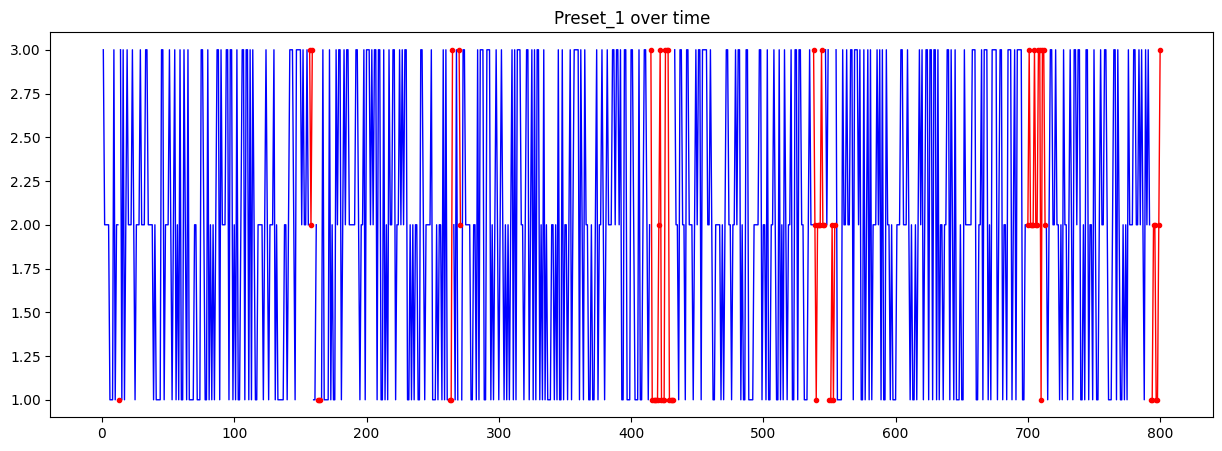

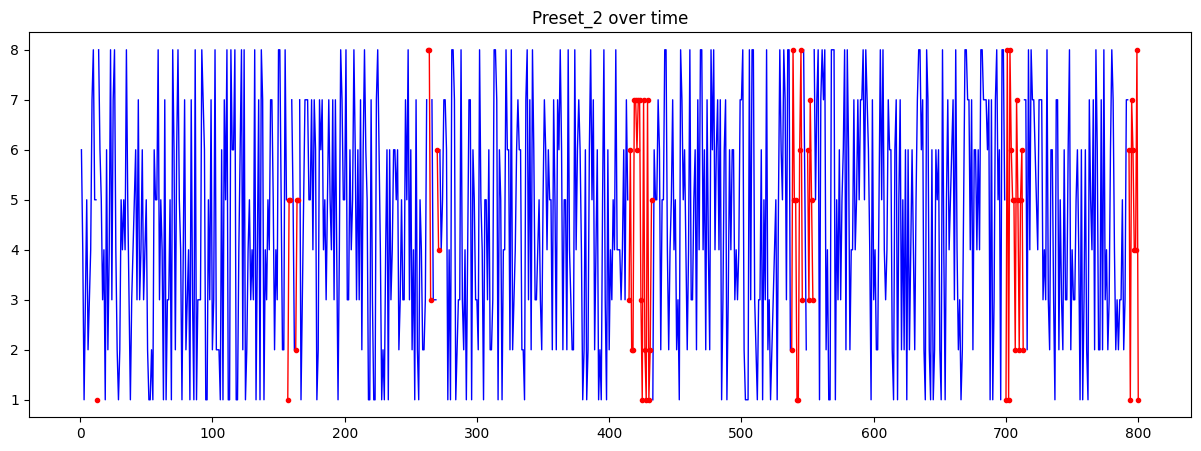

In [293]:
for var in ["Preset_1", "Preset_2"]:
    plt.figure(figsize=(15, 5))

    # adjustment to prevent lines of different colors crossing the chart
    df_op = df_oge.copy()
    df_fail = df_oge.copy()

    df_op[var] = np.where(df_op["Fail"], np.nan, df_op[var])
    df_fail[var] = np.where(df_fail["Fail"], df_fail[var], np.nan)

    plt.plot(df_op["Cycle"], df_op[var], color='b', linewidth=1)
    plt.plot(df_fail["Cycle"], df_fail[var], color='r', linewidth=1, marker="o", markersize=3)

    plt.title(f"{var} over time")
    plt.show()
